# Проект для «Викишоп»

**Описание проекта:**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель проекта:** 

Обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении находится набор данных с разметкой о токсичности правок.

**Примечание:** Необходимо построить модель со значением метрики качества F1 не меньше 0.75.

**Описание данных:** 

Данные находятся в файле 'toxic_comments.csv'. Столбец 'text' в нём содержит текст комментария, а 'toxic' — целевой признак.

**План работы с проектом:**
1. Загрузка и подготовка данных;
2. Обучение разных моделей;
3. Тестирование моделей;
4. Формирование итоговых выводов.

## Загрузка и подготовка данных

### Изучение данных

In [1]:
# установим библиотеки, необходимые для работы
!pip install torch 

In [2]:
!pip install nltk

In [26]:
# загрузим стандартные библиотеки, необходимые для работы
import pandas as pd
import sklearn
import numpy as np
import re
import time

# загрузим библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns

# загрузим модули для работыы над конкретной задачей
import torch
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import lightgbm as lgb
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# зададим константу
RANDOM_STATE = 42

In [4]:
# загрузим и подготовим "стоп-слова" для обработки текстов
# загружаем список "стоп-слов"
nltk.download('stopwords')
# загружаем токенизатор для корректной обработки сокращений, аббревиатур и т.д.
nltk.download('punkt')
nltk.download('punkt_tab')
# загружаем лексическую базу английского языка
nltk.download('wordnet')
# загрузим модель для POS-тегов
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


# создаем мн-во "стоп-слов" для английского языка
stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

In [5]:
# добавим отображение всего текста
pd.set_option('display.max_colwidth', None)

# загрузим данные и посмотрим первые пять строк получившейся таблицы
try:
    # локальный путь к файлу
    data = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Машинное_обучение_для_текстов/toxic_comments.csv')
except:
    # путь к файлу в тренажере
    data = pd.read_csv('/datasets/toxic_comments.csv')

# посмотрим первые 5 строк датафрема
data.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


**Примечание:** При загрузке данных видим, что вылезает "безыменный" столбец 'Unnamed: 0', который полностью дублирует индексацию таблицы, поэтому загрузим данные повторно с учетом этого нюанса *(образовавшийся столбец будет удален)*

In [6]:
# добавим отображение всего текста
pd.set_option('display.max_colwidth', None)

# загрузим данные и посмотрим первые пять строк получившейся таблицы
try:
    # локальный путь к файлу
    data = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Машинное_обучение_для_текстов/toxic_comments.csv').drop('Unnamed: 0', axis=1)
except:
    # путь к файлу в тренажере
    data = pd.read_csv('/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)

# посмотрим первые 5 строк датафрема
data.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [7]:
# посмотрим общую инфрмацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
# по полученной инф-ии пропуски отсутствуют, однако, проверим это повторно
data.isna().sum()

text     0
toxic    0
dtype: int64

**Примечание:** Данные соответствуют описанию задачи, типы данных приведены корректно, пропуски отсутствуют.

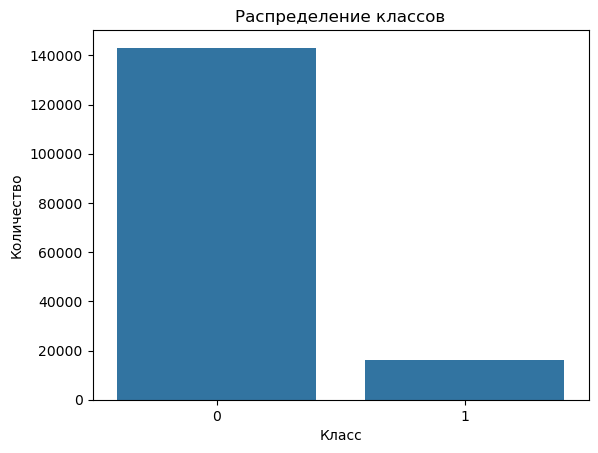

In [9]:
# проанализируем баланс классов
sns.countplot(data=data, x='toxic')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

In [10]:
# посмотрим более детально на распределение баланса классов, тогда будет:
# 0 - нетоксичный;
# 1 - токсичный
class_counts = data['toxic'].value_counts()
ratio = class_counts[0] / class_counts[1]
print(f'Отношение классов 0:1 = {ratio:.2f}:1')

Отношение классов 0:1 = 8.84:1


In [11]:
# отдельно посмотрим кол-во нетоксичных и токсичных комментариев
print(f'Количество нетоксичных комментариев: {data['toxic'].value_counts()[0]}')
print(f'Количество токсичных комментариев: {data['toxic'].value_counts()[1]}')

Количество нетоксичных комментариев: 143106
Количество токсичных комментариев: 16186


**Примечание:** Выявлен яркий дисбаланс классов, который нужно учитывать при построении моделей.

### Подготовка данных

Так как в нашей задаче говорится о сообщениях в социальной сети (вики-сообщество), то для работы с ними лучше использовать токенизатор 'TweetTokenizer', который разработан для обработки текстов из социальных сетей (особенно твитов). Он учитывает особенности неформального языка: хэштеги, упоминания, эмодзи, сокращения и орфографические ошибки.

In [17]:
lemmatizer = WordNetLemmatizer()

# собственная функция для очистки и обработки текста
def lemmatize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, pos='v' if tag.startswith('V') else 'n')
        for word, tag in tagged
    ]
    return " ".join(lemmatized)

In [18]:
# применим полученную функцию к датафрейму
data['text_lemmat'] = data['text'].apply(lemmatize_text)

In [19]:
# посмотрим первые 5 строк получившейся таблицы
data.head()

,text,toxic,text_lemmat
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they werent vandalism just closure on some gas after i vote at new york doll fac and please dont remove the template from the talk page since im retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,daww he match this background colour im seemingly stick with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man im really not try to edit war it just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i cant make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if noone else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it list in the relevant form eg wikipediagoodarticlenominationstransport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page thats on


**Обобщающий вывод этапа "Загрузка и подготовка данных":**
1. Удален "безыменный" столбец 'Unnamed: 0', который полностью дублирует индексацию таблицы.
2. Данные соответствуют описанию задачи, типы данных приведены корректно, пропуски отсутствуют.
3. Выявлен яркий дисбаланс классов, который нужно учитывать при построении моделей. Отношение классов 0 (нетоксичный):1 (токсичный) = 8.84:1.
4. Проведена очистка и лемматизация текста.

## Обучение разных моделей

### Подготовка выборок для обучения моделей

In [20]:
# разделим данные на признаки и целевой признак
X = data['text_lemmat']
y = data['toxic']

In [21]:
# разделим данные на обучающую и тестовую выборки
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=data['toxic'])

# выделим из тестовой выборки валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

# проверим получившиеся размеры выборок
print(f'Тренировочная выборка: {X_train.shape}, Валидационная выборка: {X_valid.shape}, Тестовая выборка: {X_test.shape}')

Тренировочная выборка: (95574,), Валидационная выборка: (31859,), Тестовая выборка: (31859,)


In [22]:
# дополнительно добавим копирование получившихся выборок, чтобы использовать пайплайн для одной из моделей
X_train = X_train.copy()
X_valid = X_valid.copy()
X_test = X_test.copy()

In [23]:
# проведем векторизацию данных
tfidf = TfidfVectorizer(stop_words=stopwords)
                        
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
# создадим результирующую таблицу для хранения результатов
results_df = pd.DataFrame(columns=['Model', 'Vectorizer', 'F1 (valid)'])

# собственная функция для добавления строк в таблицу
def add_result(model_name, vectorizer_name, f1_valid):
    global results_df
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            'Model': [model_name],
            'Vectorizer': [vectorizer_name],
            'F1 (valid)': [round(f1_valid, 4)]
        })
    ], ignore_index=True)

### Модель: LogisticRegression

In [27]:
# pipeline: векторизация + модель
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE))
])

In [28]:
# создадим набор гиперпараметров для модели логистической регрессии
param_grid = {
    'logreg__C': [0.5, 1, 2, 3, 5]
}

In [29]:
# найдем лучшие параметры и обучим модель
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [30]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 25.8 s
Wall time: 2min 51s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                                                                    "aren't",
                                                                    'as', 'at',
                                                                    'be',
                                                                    'because',
                                                                    'been',
                                                                    'before',
                                                                    'being',
                                                                    'below',
                                                                    'between',
                                                                    'both',
                                                                    'but', 'by',
                                                                    'can',
                                                                    'couldn',
                                                                    "couldn't", ...])),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'logreg__C': [0.5, 1, 2, 3, 5]},
             scoring='f1', verbose=1)

In [31]:
# обучим модель на основе лучших гиперпараметров
y_valid_pred_lr = grid.predict(X_valid)
f1_valid_lr = f1_score(y_valid, y_valid_pred_lr)

In [32]:
print(f"F1 на валидационной выборке для LogisticRegression: {f1_valid_lr:.4f}")
add_result('LogisticRegression', 'TF-IDF', f1_valid_lr)

F1 на валидационной выборке для LogisticRegression: 0.7560


### Модель: RandomForestClassifier

**Примечание:** Была проведена попытка подбора гиперпараметров для модели RandomForestClassifier с помощью GridSearchCV, однако, это занимает достаточно много времени, после 1-1.30 часа подбора, консоль продолжала отображать "загрузку". Поэтому с целью адекватной скорости запуска кода и быстрой его загрузкой во время проверки, подбор гиперпараметров будет осуществляться **вручную**. 

In [33]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)

In [34]:
%%time
model_rfc.fit(X_train_tfidf, y_train)

CPU times: total: 47min 26s
Wall time: 13min 22s


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [35]:
# проведем предсказания
y_valid_pred_rfc = model_rfc.predict(X_valid_tfidf)
f1_valid_rfc = f1_score(y_valid, y_valid_pred_rfc)
print(f"F1 на валидационной выборке для RandomForestClassifier: {f1_valid_rfc:.4f}")

# сразу добавим результат в общую таблицу
add_result('RandomForestClassifier', 'TF-IDF', f1_valid_rfc)

F1 на валидационной выборке для RandomForestClassifier: 0.6040


### Модель: LightGBM

In [36]:
# cнова рассчитываем scale_pos_weight (дисбаланс классов), для возможности учета его в модели
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Дисбаланс классов: {scale_pos_weight:.2f}")

Дисбаланс классов: 8.84


In [37]:
# создаем и обучем модель
model_lgb = lgb.LGBMClassifier(random_state=RANDOM_STATE, 
                               class_weight=None, 
                               scale_pos_weight=scale_pos_weight, 
                               n_estimators=100, 
                               learning_rate=0.1, 
                               n_jobs=-1)

In [38]:
%%time
model_lgb.fit(X_train_tfidf, y_train)

[LightGBM] [Info] Number of positive: 9712, number of negative: 85862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.351431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436167
[LightGBM] [Info] Number of data points in the train set: 95574, number of used features: 8273
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101618 -> initscore=-2.179379
[LightGBM] [Info] Start training from score -2.179379
CPU times: total: 2min 21s
Wall time: 41.9 s


LGBMClassifier(n_jobs=-1, random_state=42, scale_pos_weight=8.840815485996705)

In [39]:
# проведем предсказания
y_valid_pred_lgb = model_lgb.predict(X_valid_tfidf)
f1_valid_lgb = f1_score(y_valid, y_valid_pred_lgb)
print(f"F1 на валидационной выборке для LightGBM: {f1_valid_lgb:.4f}")

# сразу добавим результат в общую таблицу
add_result('LightGBM', 'TF-IDF', f1_valid_lgb)

F1 на валидационной выборке для LightGBM: 0.7256


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

**Обобщающий вывод этапа "Обучение разных моделей":**
1. Для обучения моделей данные были разделены на тренировочную, валидационную и тестовую выборки.
2. Была проведена векторизация данных, а также создана обобщающая итоговая таблица для сбора всех результатов.
3. На валидационной выборке были обучены модели: LogisticRegression, RandomForestClassifier и LightGBM. И полученны их метрики оценки качества F1.

## Тестирование моделей

In [40]:
results_df.sort_values(by='F1 (valid)', ascending=False)

,Model,Vectorizer,F1 (valid)
0,LogisticRegression,TF-IDF,0.7560
2,LightGBM,TF-IDF,0.7256
1,RandomForestClassifier,TF-IDF,0.6040


**Примечание:** Лучшей моделью по метрике оценки качества F1 на валидационной выборке оказалась LogisticRegression, так как она полностью соответствует критерию от заказчика, что значение метрики качества F1 должно быть не меньше 0.75. Также она показала наилучший результат по скорости обучения. Эту модель и будем использовать для предсказания на тестовой выборке.

In [41]:
# проводим объединение обучающей и валидационной выборок
X_full_train = pd.concat([X_train, X_valid])
y_full_train = pd.concat([y_train, y_valid])

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ⚠️\
<span style="color: darkorange"> Валидационные даные нельзя применять для обучения моделей ведь мы вбирали по ним Лучшую модель.</span>

<span style="color: purple; font-weight: bold">Комментарий студента: Хорошо, будет учтено в будущих проектах! </span>

In [42]:
# выбираем лучшую модель и обучаем ее
final_model = grid.best_estimator_
final_model.fit(X_full_train, y_full_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...])),
                ('logreg',
                 LogisticRegression(C=5, class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [43]:
# проведем предсказание лучшей модели
y_test_pred = final_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 на тестовой выборке для LogisticRegression: {f1_test:.4f}")

F1 на тестовой выборке для LogisticRegression: 0.7586


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

**Обобщающие выводы этапа "Тестирование моделей":**
1. На данном этапе была выбрана лучшая модель поле обучения всех моделей, такой оказалась LogisticRegression, которая показала наилучшее значение метрики качества F1 на валидационной выборке, равное 0.7560.
2. На основе лучшей модели было выполнено предсказание на тестовой выборке, которое показало значение метрики оценки качества, равное 0.7586, что полностью удобвлетворяет условию задачи: "Постройте модель со значением метрики качества F1 не меньше 0.75".

## Итоговые выводы

В ходе работы были проанализированы данные, предоставленные интернет-магазином «Викишоп», который хочет разработать модель, позволяющую классифицировать комментарии на позитивные и негативные.

Для реализации этой задачи было выполнено 3 этапа работы.

На **1 этапе: Загрузка и подготовка данных** были проанализированы все исходные данные и получены следующие результаты:
1. Удален "безыменный" столбец 'Unnamed: 0', который полностью дублирует индексацию таблицы.
2. Данные соответствуют описанию задачи, типы данных приведены корректно, пропуски отсутствуют.
3. Выявлен яркий дисбаланс классов, который нужно учитывать при построении моделей. Отношение классов 0 (нетоксичный):1 (токсичный) = 8.84:1.
4. Проведена очистка и лемматизация текста.

На **2 этапе: Обучение разных моделей** были получены следующие результаты:
1. Для обучения моделей данные были разделены на тренировочную, валидационную и тестовую выборки.
2. Была проведена векторизация данных, а также создана обобщающая итоговая таблица для сбора всех результатов.
3. На валидационной выборке были обучены модели: LogisticRegression, RandomForestClassifier и LightGBM. И полученны их метрики оценки качества F1.

На **3 этапе: Тестирование моделей** было сделано:
1. На данном этапе была выбрана лучшая модель поле обучения всех моделей, такой оказалась LogisticRegression, которая показала наилучшее значение метрики качества F1 на валидационной выборке, равное 0.7560.
2. На основе лучшей модели было выполнено предсказание на тестовой выборке, которое показало значение метрики оценки качества, равное 0.7586, что полностью удобвлетворяет условию задачи: "Постройте модель со значением метрики качества F1 не меньше 0.75".

**Таким образом**, наилучшей моделью для классификации комментариев на позитивные и негативные является LogisticRegression с метрикой оценки качества на тестовой выборке, равной 0.7586, что полностью удобвлетворяет условию задачи: "Постройте модель со значением метрики качества F1 не меньше 0.75".

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Валерия, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Поправь Лемматизацию.</font></ul>
<ul><font color='red'>Не применяй кросс-валиидацию если предобработка не в Pipeline.</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='orange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>